In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.colors import LogNorm

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.colors import LogNorm

def henon_heiles(t, state):
    """
    Hénon-Heiles system differential equations
    
    The system describes a particle moving in a potential:
    V(x,y) = 1/2(x² + y²) + x²y - y³/3
    
    State vector: [x, y, px, py]
    """
    x, y, px, py = state
    
    # Equations of motion
    dxdt = px
    dydt = py
    dpxdt = -x - 2*x*y
    dpydt = -y - x**2 + y**2
    
    return [dxdt, dydt, dpxdt, dpydt]

def compute_energy(state):
    """Compute the total energy (Hamiltonian) of the system"""
    x, y, px, py = state
    kinetic = 0.5 * (px**2 + py**2)
    potential = 0.5 * (x**2 + y**2) + x**2 * y - y**3 / 3
    return kinetic + potential

def poincare_section(trajectory, y_section=0.0, direction='positive'):
    """
    Compute Poincaré section at y = y_section
    Returns points where trajectory crosses the section
    """
    # trajectory should be shape (4, N) where N is number of time points
    if trajectory.shape[0] != 4:
        trajectory = trajectory.T
    
    x, y, px, py = trajectory
    crossings_x = []
    crossings_px = []
    
    for i in range(len(y) - 1):
        # Check if trajectory crosses y = y_section
        if (y[i] - y_section) * (y[i+1] - y_section) < 0:
            # Linear interpolation to find exact crossing point
            alpha = (y_section - y[i]) / (y[i+1] - y[i])
            x_cross = x[i] + alpha * (x[i+1] - x[i])
            px_cross = px[i] + alpha * (px[i+1] - px[i])
            py_cross = py[i] + alpha * (py[i+1] - py[i])
            
            # Check direction of crossing
            if direction == 'positive' and py_cross > 0:
                crossings_x.append(x_cross)
                crossings_px.append(px_cross)
            elif direction == 'negative' and py_cross < 0:
                crossings_x.append(x_cross)
                crossings_px.append(px_cross)
            elif direction == 'both':
                crossings_x.append(x_cross)
                crossings_px.append(px_cross)
    
    return np.array(crossings_x), np.array(crossings_px)

def generate_poincare_map(energy_level=0.12, n_trajectories=50, max_time=200):
    """
    Generate Poincaré map for the Hénon-Heiles system
    
    Parameters:
    - energy_level: Total energy of the system
    - n_trajectories: Number of initial conditions to try
    - max_time: Integration time for each trajectory
    """
    all_x_crossings = []
    all_px_crossings = []
    successful_trajectories = 0
    
    # Generate initial conditions with specified energy
    np.random.seed(42)  # For reproducibility
    
    attempts = 0
    while successful_trajectories < n_trajectories and attempts < n_trajectories * 3:
        attempts += 1
        
        # Random initial position
        x0 = np.random.uniform(-0.5, 0.5)
        y0 = 0.0  # Start on Poincaré section
        
        # Calculate required momentum to achieve desired energy
        # E = px²/2 + py²/2 + V(x,y)
        # At y=0: V(x,0) = x²/2
        potential_energy = 0.5 * x0**2
        
        if potential_energy >= energy_level:
            continue  # Skip if potential energy exceeds total energy
            
        available_kinetic = energy_level - potential_energy
        
        # Random distribution of kinetic energy between px and py
        max_px = np.sqrt(2 * available_kinetic)
        px0 = np.random.uniform(-max_px, max_px)
        py_squared = 2 * available_kinetic - px0**2
        
        if py_squared <= 0:
            continue
            
        py0 = np.sqrt(py_squared)  # Always start with positive py
        
        initial_state = [x0, y0, px0, py0]
        
        # Verify energy
        actual_energy = compute_energy(initial_state)
        if abs(actual_energy - energy_level) > 1e-6:
            continue
        
        # Integrate the system
        t_span = (0, max_time)
        t_eval = np.linspace(0, max_time, int(max_time * 50))  # Reduced density
        
        try:
            sol = solve_ivp(henon_heiles, t_span, initial_state, 
                          t_eval=t_eval, rtol=1e-8, atol=1e-10, method='DOP853')
            
            if sol.success and len(sol.t) > 10:  # Make sure we have enough points
                trajectory = sol.y  # This is shape (4, N)
                
                # Compute Poincaré section
                x_cross, px_cross = poincare_section(trajectory, y_section=0.0, 
                                                   direction='positive')
                
                if len(x_cross) > 0:  # Only count if we got crossings
                    all_x_crossings.extend(x_cross)
                    all_px_crossings.extend(px_cross)
                    successful_trajectories += 1
                
        except Exception as e:
            print(f"Integration failed for initial condition {initial_state}: {e}")
            continue
    
    print(f"Successfully computed {successful_trajectories} trajectories out of {attempts} attempts")
    return np.array(all_x_crossings), np.array(all_px_crossings)

def plot_poincare_maps():
    """Plot Poincaré maps for different energy levels"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Hénon-Heiles System: Poincaré Maps at y=0, py>0', fontsize=14)
    
    energy_levels = [0.04, 0.06, 0.08, 0.10]
    titles = ['E = 0.02 (Regular)', 'E = 0. (Mixed)',
                'E = 0.08 (Regular)', 'E = 0.12 (Mixed)', 
                'E = 0.16 (More Chaotic)', 'E = 0.20 (Highly Chaotic)']
    
    for i, (energy, title) in enumerate(zip(energy_levels, titles)):
        ax = axes[i//2, i%2]
        
        print(f"Computing Poincaré map for E = {energy}")
        x_cross, px_cross = generate_poincare_map(energy_level=energy, 
                                                 n_trajectories=120, 
                                                 max_time=500)
        
        if len(x_cross) > 0:
            ax.scatter(x_cross, px_cross, marker='.', s=0.25, alpha=0.6, c='blue')
            ax.set_xlim(min(x_cross), max(x_cross))
            ax.set_xlim(min(px_cross), max(px_cross))
            ax.set_xlabel('x')
            ax.set_ylabel('px')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No crossings found', ha='center', va='center')
            ax.set_title(title)
    
    plt.tight_layout()
    plt.show()



Computing Poincaré map for E = 0.04
Successfully computed 120 trajectories out of 219 attempts
Computing Poincaré map for E = 0.06
Successfully computed 120 trajectories out of 183 attempts
Computing Poincaré map for E = 0.08
Successfully computed 120 trajectories out of 152 attempts
Computing Poincaré map for E = 0.1
Successfully computed 120 trajectories out of 135 attempts


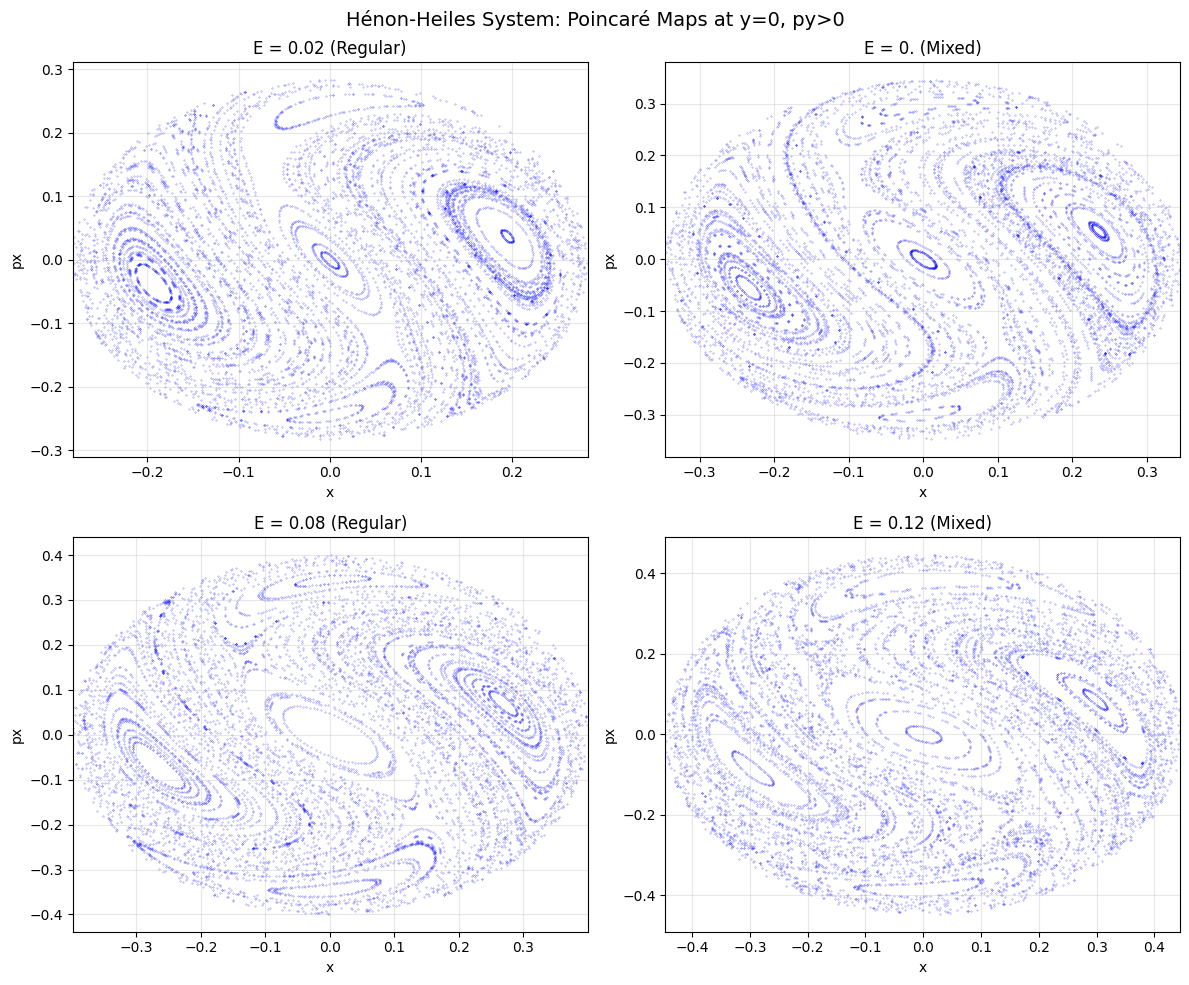

In [35]:
# Plot Poincaré maps for different energy levels
plot_poincare_maps()